In [1]:
# Install the following librairies (it is better to create a venv (or conda) virtual environment first and install these librairies in it)
!pip install mlflow
!pip install --upgrade jinja2
!pip install --upgrade Flask
!pip install setuptools



Defaulting to user installation because normal site-packages is not writeable
  Using cached mlflow-2.16.2-py3-none-any.whl.metadata (29 kB)
  Using cached mlflow_skinny-2.16.2-py3-none-any.whl.metadata (30 kB)
  Using cached docker-7.1.0-py3-none-any.whl.metadata (3.8 kB)
  Using cached graphene-3.3-py2.py3-none-any.whl.metadata (7.7 kB)
  Using cached Markdown-3.7-py3-none-any.whl.metadata (7.0 kB)
  Using cached matplotlib-3.9.2-cp312-cp312-win_amd64.whl.metadata (11 kB)
  Using cached SQLAlchemy-2.0.35-cp312-cp312-win_amd64.whl.metadata (9.9 kB)
  Using cached waitress-3.0.0-py3-none-any.whl.metadata (4.2 kB)
  Using cached cloudpickle-3.0.0-py3-none-any.whl.metadata (7.0 kB)
  Using cached importlib_metadata-8.5.0-py3-none-any.whl.metadata (4.8 kB)
  Using cached opentelemetry_api-1.27.0-py3-none-any.whl.metadata (1.4 kB)
  Using cached opentelemetry_sdk-1.27.0-py3-none-any.whl.metadata (1.5 kB)
  Using cached sqlparse-0.5.1-py3-none-any.whl.metadata (3.9 kB)
  Using cached Mako-1

In [49]:

# starts an MLflow server locally.
# Lauch in terminal
# !mlflow server --host 127.0.0.1 --port 8080


In [3]:
!pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)


In [4]:
# Importer les bibliothèques nécessaires
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from mlflow import MlflowClient
import mlflow
import pickle

In [5]:
# In order to connect to the tracking server, we’ll need to use the uri that we assigned the server when we started it.

client = MlflowClient(tracking_uri="http://127.0.0.1:8080")

#it allows programmatic interaction with the MLflow tracking server.

In [6]:
feeling_experiment = mlflow.set_experiment("Feeling_Models")

2024/09/26 23:19:09 INFO mlflow.tracking.fluent: Experiment with name 'Feeling_Models' does not exist. Creating a new experiment.


## Load and Explore
- Let's quick load and explore to see which one should be the best suitable for this project and for the constraint of available resources, including time, cpu, gpu

In [7]:
# Get dataset paths
df_path = 'Loan_Data.csv'

In [8]:
import pandas as pd

# Load datasets
df = pd.read_csv(df_path)
df.columns

Index(['customer_id', 'credit_lines_outstanding', 'loan_amt_outstanding',
       'total_debt_outstanding', 'income', 'years_employed', 'fico_score',
       'default'],
      dtype='object')

In [9]:
 # Show some sample of each df
df.head(3)

,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default
0,8153374,0,5221.545193,3915.471226,78039.38546,5,605,0
1,7442532,5,1958.928726,8228.752520,26648.43525,2,572,1
2,2256073,0,3363.009259,2027.830850,65866.71246,4,602,0


In [10]:
# print info of each df
print('Dataset #1 Info: \n')
print(df.info())



Dataset #1 Info: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_id               10000 non-null  int64  
 1   credit_lines_outstanding  10000 non-null  int64  
 2   loan_amt_outstanding      10000 non-null  float64
 3   total_debt_outstanding    10000 non-null  float64
 4   income                    10000 non-null  float64
 5   years_employed            10000 non-null  int64  
 6   fico_score                10000 non-null  int64  
 7   default                   10000 non-null  int64  
dtypes: float64(3), int64(5)
memory usage: 625.1 KB
None


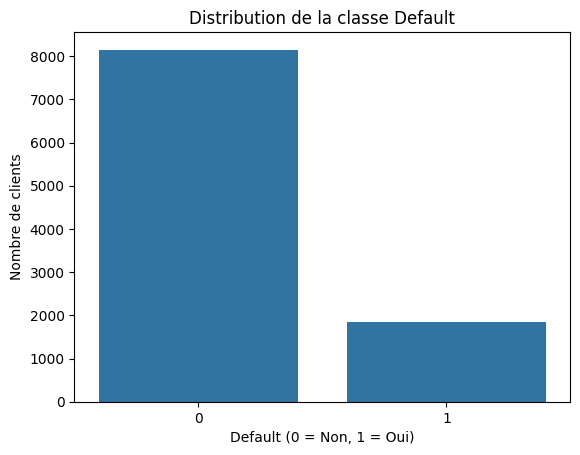

In [11]:
# Compter les occurrences de chaque classe de défaut
default_counts = df['default'].value_counts()

# Bar plot
sns.barplot(x=default_counts.index, y=default_counts.values)
plt.title('Distribution de la classe Default')
plt.xlabel('Default (0 = Non, 1 = Oui)')
plt.ylabel('Nombre de clients')
plt.show()


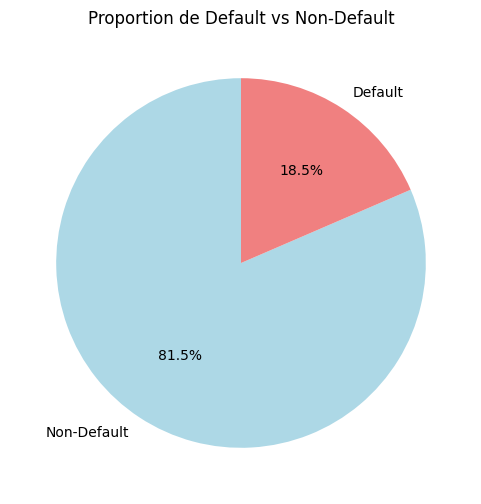

In [12]:
# Pie chart pour la classe default
plt.figure(figsize=(6,6))
plt.pie(default_counts, labels=['Non-Default', 'Default'], autopct='%1.1f%%', startangle=90, colors=['lightblue', 'lightcoral'])
plt.title('Proportion de Default vs Non-Default')
plt.show()


In [13]:
# Calculer le nombre de valeurs nulles par colonne
valeurs_nulles = df.isnull().sum()

# Afficher le résultat
print(valeurs_nulles)


customer_id                 0
credit_lines_outstanding    0
loan_amt_outstanding        0
total_debt_outstanding      0
income                      0
years_employed              0
fico_score                  0
default                     0
dtype: int64


# 2. Modeling a sentiment classifier
- The objective is to
    - Load the chosen dataset
    -  Selecting main features for modeling sentiment classifier
    -  Cleaning Tweet texts
    -  Balancing the dataset by sentiment class
    -  Split the dataset into train, validation and test subsets
    -  Train two sentiment classifiers
        - One for base ML method: Logistic Regression
        - One for advanced DL method: fine-tuning BERT model
    - Inference
    - Calculate the metrics
    - Comparing the performance of different models


In [14]:
# Count the sentiment labels by class
df['default'].value_counts().sort_values(ascending=False)

default
0    8149
1    1851
Name: count, dtype: int64

In [15]:
# Supprimer la colonne customer_id car elle n'est pas pertinente pour la modélisation
X = df.drop(['customer_id','default'], axis=1)
y = df['default']

In [16]:
# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [17]:
# Standardiser les données
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [18]:
# Étape 3: Model Engineering

# 1. Régression Logistique
logreg = LogisticRegression()
logreg.fit(X_train_scaled, y_train)

LogisticRegression()

In [19]:
# Prédictions et évaluation
y_pred_logreg = logreg.predict(X_test_scaled)
print("Régression Logistique - Classification Report")
print(classification_report(y_test, y_pred_logreg))
print("ROC AUC Score:", roc_auc_score(y_test, logreg.predict_proba(X_test_scaled)[:, 1]))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_logreg))



Régression Logistique - Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1652
           1       0.99      0.98      0.99       348

    accuracy                           1.00      2000
   macro avg       0.99      0.99      0.99      2000
weighted avg       1.00      1.00      1.00      2000

ROC AUC Score: 0.9999565138738137
Confusion Matrix:
[[1650    2]
 [   7  341]]


In [20]:
# 2. Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_scaled, y_train)

RandomForestClassifier(random_state=42)

In [21]:
# Prédictions et évaluation
y_pred_rf = rf.predict(X_test_scaled)
print("\nRandom Forest - Classification Report")
print(classification_report(y_test, y_pred_rf))
print("ROC AUC Score:", roc_auc_score(y_test, rf.predict_proba(X_test_scaled)[:, 1]))



Random Forest - Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1652
           1       0.99      0.98      0.98       348

    accuracy                           0.99      2000
   macro avg       0.99      0.99      0.99      2000
weighted avg       0.99      0.99      0.99      2000

ROC AUC Score: 0.9996555898806044


In [22]:
X_train.head()

,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score
9254,0,3005.328746,4216.415038,62959.18911,5,712
1561,1,4717.704748,8760.954045,63546.22748,3,700
1670,0,5394.537878,5024.768703,81083.45762,6,704
6087,1,5367.416056,8101.373570,78087.37726,4,709
6669,1,3622.450370,7329.325832,68499.74591,5,693


In [23]:
with mlflow.start_run():

    # Étape 3: Model Engineering

    # 1. Régression Logistique
    logreg = LogisticRegression()
    logreg.fit(X_train_scaled, y_train)


    # Save Logistic Regression model
    with open("logistic_regression_model.pkl", "wb") as f:
        pickle.dump(logreg, f)

    # Save Random Forest model
    with open("random_forest_model.pkl", "wb") as f:
        pickle.dump(rf, f)

    print("Models saved successfully!")
    # Prédictions et évaluation
    y_pred_logreg = logreg.predict(X_test_scaled)
    roc_auc_logreg = roc_auc_score(y_test, logreg.predict_proba(X_test_scaled)[:, 1])

    # Enregistrer les métriques avec MLflow
    mlflow.log_metric("accuracy_logreg", logreg.score(X_test_scaled, y_test))
    mlflow.log_metric("roc_auc_logreg", roc_auc_logreg)

    # Enregistrer le modèle de régression logistique
    mlflow.sklearn.log_model(logreg, "logistic_regression_model")

    # 2. Random Forest
    rf = RandomForestClassifier(random_state=42)
    rf.fit(X_train_scaled, y_train)

    # Prédictions et évaluation
    y_pred_rf = rf.predict(X_test_scaled)
    roc_auc_rf = roc_auc_score(y_test, rf.predict_proba(X_test_scaled)[:, 1])

    # Enregistrer les métriques avec MLflow
    mlflow.log_metric("accuracy_rf", rf.score(X_test_scaled, y_test))
    mlflow.log_metric("roc_auc_rf", roc_auc_rf)

    # Enregistrer le modèle Random Forest
    mlflow.sklearn.log_model(rf, "random_forest_model")

    # Capture des métriques pour le rapport
    print("\nRégression Logistique - ROC AUC Score:", roc_auc_logreg)
    print("\nRandom Forest - ROC AUC Score:", roc_auc_rf)

# Terminer l'expérience MLflow
mlflow.end_run()

Models saved successfully!


KeyboardInterrupt: 

- **Remarks**:
    - Virgin America has the least samples but the sentiment classes are quite equal, with around 30% each each sentiment class
    - For other airways, the negative Tweets really dominate the positive and neutral groups, especially for United, US Airways and American airways.
    - It can be concluded that the Tweets are mainly used to mention the negative sentiments

## How many samples for each sentiment class?